In [50]:
import os
import numpy as np
import pymc3 as pm
import pandas as pd
import seaborn as sns
import us
import scipy.stats
from matplotlib import pyplot as plt

In [ ]:
base_dir='C:/Users/Phil/Downloads/bls'
rec=pd.read_csv(os.path.join(base_dir, 'records.csv'), parse_dates=[2])
series=pd.read_csv(os.path.join(base_dir, 'series.csv'))


In [ ]:
#function for pulling string tags ouy of the title series so we 
#can do analyses based on content
def tagger(ser, xList, default='NA'):
    nS=pd.Series(default for k in range(len(ser)))
    for x in xList:
        nS.loc[ser.str.contains(x)]=x  
    return nS
print('done') 

The relevant variables for us to look at are period, value, is_primary, is_delta, source, so we need to check for missing values
in case they need to be delt with. We also need to check for duplicate values in both of the naming columns

In [4]:
rec_nan=rec[['period', 'value']].isnull().any()
series_nan=series[['source', 'is_primary', 'is_delta']].isnull().any()
print(rec_nan, series_nan)

#print(series['id'].value_counts())
#print(rec['series_id'].value_counts())

period    False
value     False
dtype: bool source        False
is_primary    False
is_delta      False
dtype: bool


There are no missing values, but the records data has a lot of redundancy in the series_id. We're going to merge on those keys anyway and deal with it later, depending on what we want to look at.

In [5]:
main_dat=rec.merge(series, left_on='series_id', right_on='id', how='inner')

The data are highly skewed to the right in both cases so we need to identify who those extreme cases are. However, we need to tag columns with relevant categoreis first, so we can properly detect anything about the content of these cases that might seperate them.

In [91]:
states=[n.name for n in us.states.STATES]
main_dat['state']=tagger(main_dat['title'], states)
#list has to be in this oreder so that Unemployed overwrites employed
main_dat['employment']=tagger(main_dat['title'], ['Employ', 'Unemploy'])
main_dat['valueType']=tagger(main_dat['title'], ['labor force', 'percent change'])
#make a graph to see the distribution of outliers
outliers=main_dat.loc[main_dat['value'] >main_dat['value'].quantile(.9)]
#bar=outliers['state'].value_counts().plot(kind='bar', subplots=True, figsize=(16,8))


['labor force' 'NA' 'percent change']


It seems like all the data points with high values are distributed evenly across states even though a high proportion of the analyses are not state specific. Next step is too see how the over all labor force differs between states over time.

0


c:\python\python36-32\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


[Text(0,0.5,'Value in Dollars'),
 Text(0.5,0,'Months Passed Since January, 2000')]

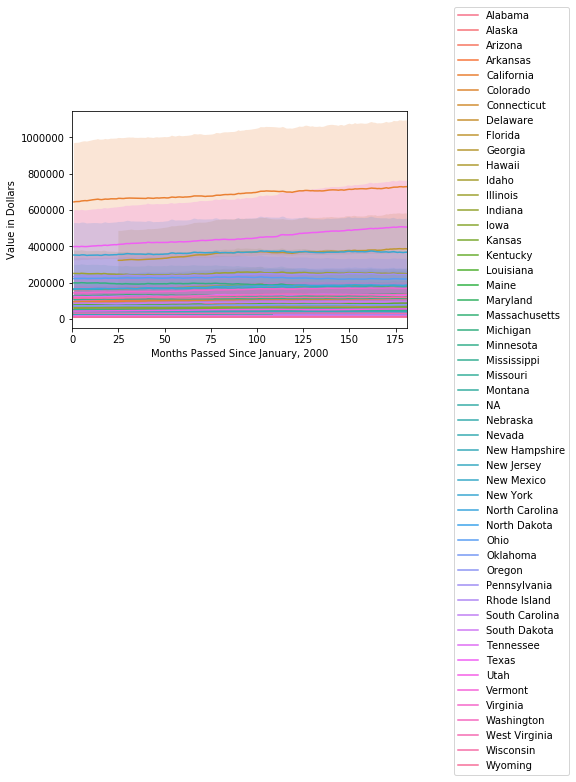

In [85]:
#quick check for duplicates in the time series so we don't have redunancy throwing us off
print(main_dat[main_dat.duplicated(subset=['series_id','period'],keep=False)].size)

#
t_dats=main_dat.groupby(['state','series_id','period', 'valueType'], as_index=False)['value'].mean()

#make the datetime into months/days passed since begging for model
minTime=t_dats.period[t_dats.period.index.min()]

t_dats['monthsPassed']=(t_dats.period-minTime)/np.timedelta64(1, 'M')
t_dats['daysPassed']=(t_dats.period-minTime).dt.days

#LAUS 
vPerT=sns.tsplot(time="monthsPassed", value="value", data=t_dats[t_dats.valueType=='labor force'],condition='state', unit='series_id')
vPerT.legend(loc=1, bbox_to_anchor=(1.5, 1.5))
vPerT.set(xlabel='Months Passed Since January, 2000', ylabel='Value in Dollars')


Most of the states didn't seem experience that much growth in the labor force in the period between 2000 - 2015. However, it looks like there may have been some growth in california during this time, but with considerable variation between reports.

c:\python\python36-32\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  # This is added back by InteractiveShellApp.init_path()
c:\python\python36-32\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


['LAUS' 'CESSM' 'CESSM-ANALYSIS' 'LAUS-ANALYSIS']


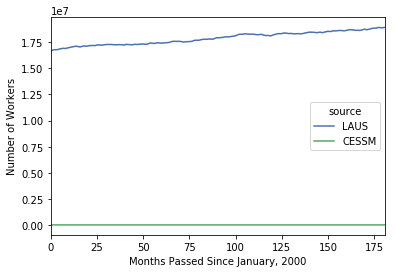

In [96]:
tc_dats=main_dat[(main_dat['state']=='California')]

#re-order so that its an odered long format. This make sure we don't get anything unexpected in the regression
tc_dats=tc_dats.sort_values(by=['series_id', 'period'])

#make the datetime into months/days passed since begging for model
minTime=tc_dats.period[tc_dats.period.index.min()]

tc_dats['monthsPassed']=(tc_dats.period-minTime)/np.timedelta64(1, 'M')
tc_dats['daysPassed']=(tc_dats.period-minTime).dt.days


#could map seaborn times series plot with facet_grid so each one is made individually
LAUS=sns.tsplot(data=tc_dats[(tc_dats['valueType']=='labor force')], time="monthsPassed", value="value", unit='series_id', condition='source', color="deep") 
LAUS.set(xlabel='Months Passed Since January, 2000', ylabel='Number of Workers')

print(tc_dats.source.unique())

c:\python\python36-32\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


[Text(0,0.5,'Percentage Change in Labor Force'),
 Text(0.5,0,'Months Passed Since January, 2000'),
 Text(0.5,1,'Change in Labor Force Over Time by Source')]

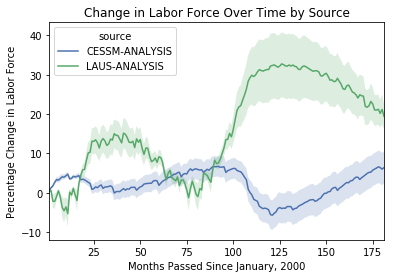

In [130]:
pCh=sns.tsplot(data=tc_dats[(tc_dats['valueType']=='percent change')], time="monthsPassed", value="value", condition='source', unit='series_id', color="deep")
pCh.set(xlabel='Months Passed Since January, 2000', ylabel='Percentage Change in Labor Force', title='Change in Labor Force Over Time by Source')


c:\python\python36-32\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


[Text(0,0.5,'Percentage Change in Labor Force'),
 Text(0.5,0,'Months Passed Since January, 2000'),
 Text(0.5,1,'Average Change in Labor Force Over Time')]

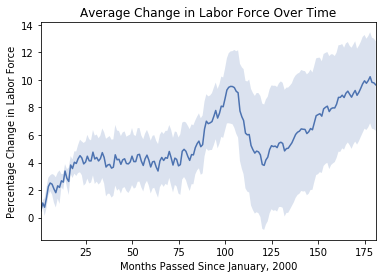

In [131]:
#see what the average between these two reports looks like 
#to confirm that it appears like linear increase
mPers=tc_dats[(tc_dats['valueType']=='percent change')].groupby(['monthsPassed', 'series_id'], as_index=False)['value'].mean()
mpCh=sns.tsplot(data=mPers, time="monthsPassed", value="value", unit='series_id', color="deep")
mpCh.set(xlabel='Months Passed Since January, 2000', ylabel='Percentage Change in Labor Force', title='Average Change in Labor Force Over Time')

These data sho highly discrepent results, and its difficult to know which one is can be more trusted without knowing more about there sampling methods or what they were measure. However, these data showing percent change seem have wave patterns of drops and increases. Perhaps fitting a sin function to these data in a hiearchical linear model could tell us how each one sees this patten.

In [119]:
LAUS_dats=tc_dats[(tc_dats['valueType']=='percent change') & (tc_dats['source']=='LAUS-ANALYSIS')]
LAUS_model=pm.Model()

#replace the series_ids with numbers that indicate the relative poistion in the 
#list. This is need for the modeling, which needs to index a prior matix
replace_dict=dict(zip(LAUS_dats.series_id.unique(), np.arange(len(LAUS_dats.series_id.unique()))))
LAUS_dats.series_id.replace(to_replace=replace_dict,
                                  inplace=True)
with LAUS_model:
    
    #start with group level distributions, centered at overall mean
    mu_b0=pm.Normal('mu_b0', mu=np.mean(LAUS_dats.value), sd=20)
    sig_b0=pm.HalfNormal('sig_b0', sd=2)
    mu_b1=pm.Normal('mu_b1', mu=0, sd=5) 
    sig_b1=pm.HalfNormal('sig_b1', sd=2)
    
    #specify individual model
    i_b0 = pm.Normal('i_b0', mu=mu_b0, sd=sig_b0, shape=len(LAUS_dats.series_id.unique()))
    # Intercept for each county, distributed around group mean mu_a
    i_b1 = pm.Normal('i_b1', mu=mu_b1, sd=sig_b1, shape=len(LAUS_dats.series_id.unique()))
    
    mu=i_b0[LAUS_dats.series_id.values]+i_b1[LAUS_dats.series_id.values]*(LAUS_dats.monthsPassed)
    
    #error for the model
    eps = pm.HalfCauchy('eps', 5)
    
    Y_obs = pm.Normal('Y_obs', mu=mu, sd=eps, observed=LAUS_dats.value)
    

map_estimate = pm.find_MAP(model=LAUS_model)
print (map_estimate)

c:\python\python36-32\lib\site-packages\pandas\core\generic.py:4619: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
logp = -5,490.7, ||grad|| = 402.02: 100%|█████████████████████████████████████████████| 38/38 [00:00<00:00, 435.91it/s]


{'mu_b0': array(16.40324239), 'sig_b0_log__': array(3.69948305), 'mu_b1': array(0.), 'sig_b1_log__': array(-2203.53036443), 'mu_b3': array(0.), 'sig_b3_log__': array(-2205.42748442), 'i_b0': array([10.48528734, 26.2143857 , 28.54723622,  5.91321737,  4.44684542,
       29.09838307,  0.16767741, 26.3529066 ]), 'i_b1': array([0., 0., 0., 0., 0., 0., 0., 0.]), 'i_b3': array([0., 0., 0., 0., 0., 0., 0., 0.]), 'eps_log__': array(1.23823034), 'sig_b0': array(40.42640034), 'sig_b1': array(0.), 'sig_b3': array(0.), 'eps': array(3.4495036)}


In [104]:
print(LAUS_dats.series_id.values)

[56 56 56 ... 63 63 63]


In [118]:
CESSM_dats=tc_dats[(tc_dats['valueType']=='percent change') & (tc_dats['source']=='CESSM-ANALYSIS')]
CESSM_model=pm.Model()

rep_dict=dict(zip(CESSM_dats.series_id.unique(), np.arange(len(CESSM_dats.series_id.unique()))))
CESSM_dats.series_id.replace(to_replace=rep_dict,
                                  inplace=True)

with CESSM_model:
    
    #start with group level distributions, centered at overall mean
    mu_b0=pm.Normal('mu_b0', mu=np.mean(CESSM_dats.value), sd=10)
    sig_b0=pm.HalfNormal('sig_b0', sd=2)
    mu_b1=pm.Normal('mu_b1', mu=0, sd=5) #making beta1 uniform just for fun
    sig_b1=pm.HalfNormal('sig_b1', sd=2)
    
    
    #specify individual model
    i_b0 = pm.Normal('i_b0', mu=mu_b0, sd=sig_b0, shape=len(CESSM_dats.series_id.unique()))
    # Intercept for each county, distributed around group mean mu_a
    i_b1 = pm.Normal('i_b1', mu=mu_b1, sd=sig_b1, shape=len(CESSM_dats.series_id.unique()))
    
    mu=i_b0[CESSM_dats.series_id.values]+i_b1[CESSM_dats.series_id.values]*np.sin(CESSM_dats.monthsPassed)
    
    #error for the model
    eps = pm.HalfCauchy('eps', 5)
    
    Y_obs = pm.Normal('Y_obs', mu=mu, sd=eps, observed=CESSM_dats.value)
    

map_estimate2 = pm.find_MAP(model=CESSM_model)
print (map_estimate2)

c:\python\python36-32\lib\site-packages\pandas\core\generic.py:4619: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
logp = -16,307, ||grad|| = 63.499: 100%|████████████████████████████████████████████| 138/138 [00:00<00:00, 580.40it/s]


{'mu_b0': array(1.98676486), 'sig_b0_log__': array(2.02820175), 'mu_b1': array(-0.02009524), 'sig_b1_log__': array(-17.3317302), 'i_b0': array([ 11.20477107,   8.56301983,   2.59464   , -11.96590086,
         1.44041866,   3.98363387,   1.18991554,   3.18684177,
        -6.41973476,   3.7191462 ,   3.01255341,   3.30674168,
         3.79914043,  -5.81317833,   2.30368479,   2.84291379,
         3.76216761,   1.74621226,   4.77349054, -12.94108349,
         2.83976879,   2.62142065,  10.82011971,   7.11165705]), 'i_b1': array([-0.02009524, -0.02009524, -0.02009524, -0.02009524, -0.02009524,
       -0.02009524, -0.02009524, -0.02009524, -0.02009524, -0.02009524,
       -0.02009524, -0.02009524, -0.02009524, -0.02009524, -0.02009524,
       -0.02009524, -0.02009524, -0.02009524, -0.02009524, -0.02009524,
       -0.02009524, -0.02009524, -0.02009524, -0.02009524]), 'eps_log__': array(2.40107953), 'sig_b0': array(7.60040663), 'sig_b1': array(2.97115433e-08), 'eps': array(11.03508265)}


These data suggest that california had the largest labor force in the us, during the interval between January, 2000 and March, 2015. However, a close look at California show that the labor force seems to have fluctuated quite drastically, and that this trend upward seems to be carried by averaging between reoprt. You can see from the graphs that when you split the data by source the reports seem to diverge particulary around 100 months passed the start, approximately 4 months in 2008 year. While the LAUS report seems to be showing an increase the percent change in the labor force, the first derivative of the function for the CESSM report would indicate that there's a decline in the percentage change from year to year. The latter of these seems more likely since thats about when the economy crashed.  